# Map-Reduce operations with Send
* Map-reduce operations are essential for efficient task decomposition and parallel processing.
    * Map: Break a task into smaller sub-tasks, processing each sub-task in parallel.
    * Reduce: Aggregate the results across all of the completed, parallelized sub-tasks.

## Ummm... What is a Map-Reduce operation again??? 

If you are unfamiliar with this name and it sounds confusing to you, do not worry. The real meaning is easier to understand than the weird name. 

#### Map 
Think of it as **splitting** a big job into smaller, manageable tasks. Each smaller task can be worked on at the same time (in **parallel**).  

Example:  
* If you have to count the words in 100 books, you can give 10 books to 10 different people, and each person counts the words in their assigned books.

#### Reduce  
Once all the smaller tasks are finished, the results are **combined** to produce the final output.  

Example:  
* The 10 people report their word counts, and you **add up** all the counts to get the total number of words in the 100 books.


#### Map-Reduce Processing 
- **Map**: Divides a big task into smaller tasks.  
- **Reduce**: Combines the results of smaller tasks into the final output.

This approach saves time by **distributing work** efficiently, especially when dealing with large datasets.

## And how a map-reduce operation is done in LangGraph?
In LangGraph, the map-reduce pattern is a method for handling tasks by breaking them into smaller sub-tasks, processing these sub-tasks simultaneously, and then combining the results. This approach is particularly useful when the number of sub-tasks isn't known in advance.

#### How It Works

1. **Mapping:** Start with a main task that generates a list of items. For example, if given a general topic, the system might produce a list of related subjects.

2. **Processing in Parallel:** Each item from the list is then processed independently and at the same time. Continuing the example, for each related subject, the system could generate a joke.

3. **Reducing:** After all items have been processed, the results are combined or summarized. In our case, this could involve selecting the best joke from the list of generated jokes.

#### Challenges Addressed

- **Unknown Number of Sub-Tasks:** Since the number of items (like related subjects) may not be known beforehand, it's challenging to set up the workflow in advance.

- **Dynamic Input States:** Each sub-task might require a different input, necessitating a system that can handle varying inputs dynamically.

#### The LangGraph's Solution: using Send

As we will see below, **LangGraph uses the built-in Send API to manage these challenges**. By employing conditional edges, the Send function can distribute different inputs to multiple instances of a processing node. This means each sub-task can receive a unique input, allowing for flexible and dynamic workflow management.

This map-reduce approach in LangGraph enables efficient task decomposition and parallel processing, making it easier to handle complex workflows where the number of sub-tasks isn't predetermined. 

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 022-map-reduce.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

We will call our LangSmith project **001-langgraph**.

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Basic Map-Reduce operation example: A Joke Generator App

#### The map-reduce process
We will design an app that will do two things:
* Create a set of jokes from subjects or sub-topics related to a topic (map operation).
* Pick the best joke from the list (reduce operation).

#### The app workflow will be:
* The user will input a topic.
* The app will generate a list of subjects or sub-topics related to the topic.
* The app will generate a joke for each subject.
* The app will select the best joke generated.

## Let's start by creating the prompts we will use with the LLM

In [6]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o") 

## Let's now define the schemas that will define the format of the Subjects, BestJoke, and OverallState

In [7]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int

# PAY ATTENTION HERE: The `jokes` key will append the jokes.
# See how we are using the operator.add reducer.
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

## Now we will define the function to generate subjects or sub-topics related to the topic submitted by the user

In [8]:
# We are asking the LLM to generate subjects related with the topic
def generate_subjects(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

## Let's explain the previous code in simple terms
Here’s a simple explanation of the previous code:

1. **Purpose**: The function `generate_subjects` is designed to use a LLM (referred to as `model`) to generate a list of subjects related to a given topic.

2. **Input**: It takes in a single argument called `state`, which is a dictionary-like object (`OverallState`). This `state` contains a key `"topic"` that specifies the main topic for which related subjects should be generated.

3. **Steps**:
   - **Create a Prompt**: The `subjects_prompt.format(topic=state["topic"])` takes a predefined prompt template (`subjects_prompt`) and fills in the topic from the `state`.
   - **Ask the Model**: The LLM (`model`) is used to process this prompt. The method `with_structured_output(Subjects).invoke(prompt)` ensures the model's response is structured and follows a specific format defined in `Subjects`.
   - **Extract Subjects**: From the model's response, the `subjects` field is extracted.

4. **Output**: The function returns a dictionary with a single key, `"subjects"`, containing the list of subjects generated by the model.

#### Example:

If the topic in `state["topic"]` is `"climate change"`, the function:
1. Formats a prompt like: "Generate a list of subjects related to climate change."
2. Sends this prompt to the model.
3. Receives and processes the model's response (e.g., `["Global Warming", "Renewable Energy", "Carbon Footprint"]`).
4. Returns: `{"subjects": ["Global Warming", "Renewable Energy", "Carbon Footprint"]}`.

## Once we have the list of subjects, we will use Send to create a joke for each subject

In simple terms, the **`Send`** function in LangGraph is used to dynamically send data (called **state**) to specific nodes in a workflow, even when you don't know in advance how many nodes you'll need or what data each node will receive.  

#### Example Scenario:  
Imagine you have a process where:  
1. **Node A** creates a list of subjects (e.g., ["cats", "dogs", "robots"]).  
2. You want to send each subject to another node (**"generate_joke"**) that generates a joke about that subject.  

However, you don't know how many subjects there will be ahead of time.  

#### What Does `Send` Do?  
- It lets you create as many connections as needed **on the fly** (instead of predefining them).  
- Each connection can have its **own data** (each particular subject).  

#### Step 1: using a conditional edge, connect the "Node A" with "the Send Magic".
```python
graph.add_conditional_edges("node_a", continue_to_jokes)
```
- **Connects the "node a" to the "generate_joke" node dynamically, creating a joke from the associated subject**. 

#### Step 2: "the Send Magic" creates as many generate_joke parallel nodes as many subjects were generated by the Node A
```python
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state['subjects']]
```
- This function takes the state (e.g., a list of subjects).  
- It creates a Send object **for each subject, telling it**:  
  1. **Go to the `generate_joke` node**.  
  2. **Pass a specific subject (e.g., {"subject": "cats"}) as input**.   

#### Key Idea:
**Instead of defining fixed connections, `Send` allows the workflow to adapt based on the data at runtime**. This is especially useful for tasks like processing lists or batches of data.

#### How we will use Send in our exercise
* We will use [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject. **This can automatically parallelize joke generation for any number of subjects**.
    * `generate_joke`: the name of the node in the graph
    * `{"subject": s`}: the state to send

In [9]:
from langgraph.constants import Send

def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

## Explanation of the previous code in simple terms
The code defines a function called **`continue_to_jokes`** that takes some input data (**state**) and prepares instructions to send each item in the data to a specific processing step.

#### Breaking it down:
1. **Input: `state`**  
   - The input, called **`state`**, contains data organized like a dictionary.  
   - It has a key called **"subjects"**, which is expected to be a **list** (e.g., `["cats", "dogs", "robots"]`).

2. **Output: List of `Send` objects**  
   - For each subject in the list, the function creates a **`Send`** object.  
   - Each **`Send`** object specifies:  
     1. Go to the **"generate_joke"** node (a step in the workflow).  
     2. Pass a specific **subject** as input, like `{"subject": "cats"}`.

3. **Purpose**  
   - The function is used to **dynamically route data**.  
   - If there are 3 subjects in the list, it creates 3 `Send` instructions—one for each subject—telling the system to process each item individually.

#### Example:  
If **state["subjects"] = ["cats", "dogs"]**, the output will be:  
```
[
    Send("generate_joke", {"subject": "cats"}),  
    Send("generate_joke", {"subject": "dogs"})
]
```

This allows the workflow to handle multiple inputs (subjects) in parallel, sending each one to the **"generate_joke"** node for processing.

## Ooops! But we still have not defined the joke creator function. Let's do it now.
* We will define a node that will create our jokes, `generate_joke`.
* We will return them as `jokes` in `OverallState`.
* This key has a reducer that will combine lists.

In [10]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

# PAY ATTENTION HERE: we ask the LLM to generate a joke about a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

## Let's explain the previos code in simple terms
The previous code defines how to generate a joke about a specific subject using an LLM. Let me break it down step by step:

#### Defining Data Structures
- `JokeState` and `Joke` are like blueprints for organizing data.

  - `JokeState` tells us that we need a dictionary (or an object) with a key called `subject` that holds a string. For example:
    ```python
    state = {"subject": "cats"}
    ```
  
  - `Joke` defines the expected output format: it contains a single key, `joke`, which is also a string. For example:
    ```python
    {"joke": "Why did the cat sit on the computer? To keep an eye on the mouse!"}
    ```

#### The `generate_joke` Function
This is the main function that creates a joke based on the given subject. Here’s what happens inside:

1. **Getting the subject**:
   - The `state` parameter is expected to contain the subject for the joke (like `"cats"`).
   
2. **Preparing a prompt**:
   - The variable `prompt` is created using a pre-defined template (`joke_prompt`), where the subject is inserted. For example, if `state["subject"]` is `"cats"`, the prompt would look like:
     ```python
     "Tell me a funny joke about cats."
     ```

3. **Calling the Language Model (LLM)**:
   - The `model.with_structured_output(Joke).invoke(prompt)` sends the prompt to the LLM.
   - The LLM generates a response that matches the `Joke` structure, ensuring it returns a dictionary with a `joke` key.

4. **Returning the Joke**:
   - The response from the LLM is wrapped in another dictionary under the key `"jokes"`, so the final output might look like:
     ```python
     {"jokes": ["Why did the cat sit on the computer? To keep an eye on the mouse!"]}
     ```

#### In Summary
- The function takes a subject (e.g., `"cats"`).
- It creates a prompt asking the LLM to generate a joke about that subject.
- The LLM responds with a joke.
- The function returns the joke in a structured format.

## And, finally, let's define the fuction to select the best joke

In [11]:
# PAY ATTENTION HERE: we ask the LLM to select the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

## OK. Let's review what we just did
The previous code defines a function that helps pick the best joke from a list of jokes using a language model (LLM). Let’s break it down step by step:


#### Input Data (`state`)
- The function works with a dictionary called `state` (which follows the `OverallState` structure). It contains two key pieces of information:
  1. **`state["jokes"]`**: A list of jokes (e.g., `["Why did the chicken cross the road? To get to the other side!", "What do you call fake spaghetti? An impasta!"]`).
  2. **`state["topic"]`**: The topic the jokes are related to (e.g., `"animals"`).


#### Joining the Jokes
- The jokes from `state["jokes"]` are combined into a single string, separated by double newlines (`\n\n`). For example:
  ```python
  jokes = "Why did the chicken cross the road? To get to the other side!\n\nWhat do you call fake spaghetti? An impasta!"
  ```


#### Creating the Prompt
- The function builds a prompt using a template (`best_joke_prompt`) to ask the LLM which joke is the best. It includes:
  - The **topic** of the jokes.
  - The **list of jokes**.

The prompt would be something like:
  ```text
  "Here are some jokes about animals:
  
  1. Why did the chicken cross the road? To get to the other side!
  
  2. What do you call fake spaghetti? An impasta!
  
  Which joke is the best? Respond with the joke number."
  ```


#### Asking the LLM
- The `model.with_structured_output(BestJoke).invoke(prompt)` sends the prompt to the LLM and asks it to select the best joke. 
- The `BestJoke` structure ensures the response includes an `id`, which identifies the number or position of the selected joke.


#### Returning the Best Joke
- The function takes the `id` from the LLM’s response and uses it to look up the corresponding joke in the `state["jokes"]` list.
- The best joke is returned in a dictionary under the key `"best_selected_joke"`. For example:
  ```python
  {"best_selected_joke": "Why did the chicken cross the road? To get to the other side!"}
  ```


#### In Summary
- The function takes a list of jokes and a topic.
- It asks the LLM to pick the best joke by providing a clear prompt.
- It returns the selected joke in an easy-to-use format.

## OK. Let's now put it all together in our app

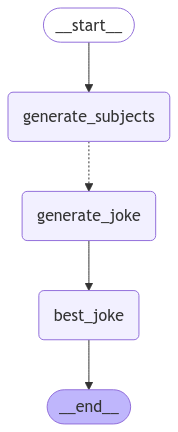

In [12]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)

# Node to generate subjects related to the topic
graph.add_node("generate_subjects", generate_subjects)

# Node to generate a joke about a subject
graph.add_node("generate_joke", generate_joke)

# Node to select the best joke
graph.add_node("best_joke", best_joke)

graph.add_edge(START, "generate_subjects")

# PAY ATTENTION HERE: see how we use the continue_to_jokes function we created with Send
graph.add_conditional_edges("generate_subjects", continue_to_jokes, ["generate_joke"])

graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

## Let's review what is going on under the hood in this app
The app defines a **map-reduce workflow** in LangGraph to generate and evaluate jokes based on a given topic. Here's a simplified explanation broken down step-by-step:

#### Purpose of the Code
The code builds a **graph-based workflow** to:
1. Generate a list of subtopics related to a given topic (**map** step).  
2. Create a joke for each subtopic (**map** step).  
3. Select the best joke from the generated ones (**reduce** step).  

#### Key Components

1. **Inputs and Outputs**:
   - **Input**: A topic provided by the user (e.g., "Technology").  
   - **Output**: The best joke related to that topic.

2. **Model Setup**:
   - Uses the selected LLM (in our example chatGPT4) to generate text outputs based on prompts.

3. **Data Models**:
   - **Subjects**: Holds the list of subtopics generated.  
   - **Joke**: Stores a joke for a specific subtopic.  
   - **BestJoke**: Keeps track of the ID of the best joke selected.

4. **State Management**:
   - **OverallState**: Tracks the topic, generated subjects, jokes, and the best-selected joke.  
   - **JokeState**: Tracks the specific subject while generating a joke.

#### Workflow Breakdown

1. **Subjects Generation** (Mapping Step):
   - **Function**: `generate_subjects()`
   - Generates 3 subtopics based on the main topic using the AI model.

2. **Joke Generation** (Mapping Step):
   - **Function**: `generate_joke()`
   - Creates a joke for each subtopic.  
   - Uses parallel processing, meaning all jokes are generated simultaneously.

3. **Dynamic Mapping**:
   - **Function**: `continue_to_jokes()`
   - Dynamically maps each generated subtopic to the joke creation node, even if the number of subtopics is unknown beforehand.

4. **Best Joke Selection** (Reduce Step):
   - **Function**: `best_joke()`
   - Combines all generated jokes and evaluates them to find the best one.  

#### Graph Construction

- **Nodes**: Represent tasks like generating topics, creating jokes, and selecting the best joke.  
- **Edges**: Define transitions between tasks.  
- **Dynamic Mapping**: Allows variable-length inputs (e.g., multiple subtopics) to be handled without predefining their count.  

#### Key Concepts in Action

- **Map Phase**:  
  - Breaks down the topic into subjects or subtopics (mapping) and processes each subtopic in parallel to generate jokes.

- **Reduce Phase**:  
  - Combines results (jokes) and selects the best one.

- **Flexibility**:  
  - Handles unknown numbers of subtopics dynamically using conditional edges.

#### Real-World Analogy

Imagine you want to prepare a comedy show based on a theme.  
1. **Topic**: "Technology."  
2. **Step 1 (Map)**: Brainstorm related subjects like "AI," "Smartphones," and "Robots."  
3. **Step 2 (Map)**: Write jokes about each subject.  
4. **Step 3 (Reduce)**: Select the funniest joke to tell at the show.

#### Final Output

The graph executes these steps, processes each stage, and outputs the **best joke** related to the given topic.

## Let's pay attention to the line where we activate the Send Magic in the previous code
In the previous code, it is important to understand the line where we are activating the "Send Magic":

```python
graph.add_conditional_edges("generate_subjects", continue_to_jokes, ["generate_joke"])
```

#### Explanation
Here's a breakdown of its components:

1. **`graph.add_conditional_edges`**:
   - This function defines edges in the state graph that are created dynamically based on some condition or computation. Unlike a static edge (e.g., `graph.add_edge`), conditional edges depend on the result of a user-defined function, which is evaluated at runtime.

2. **`"generate_subjects"`**:
   - This is the source node in the graph. After this node is processed, the graph evaluates the `continue_to_jokes` function to determine what happens next.

3. **`continue_to_jokes`**:
   - This is the custom function provided to determine the conditional edges. It takes the current `state` as input (an instance of `OverallState`) and returns a list of `Send` instructions.
   - Each `Send` specifies the next node ("generate_joke") and the associated payload (data to pass to the node). Specifically, for every subject in the `state["subjects"]` list, a `Send` is created that includes the subject as part of the payload.

   Here's the `continue_to_jokes` function:
   ```python
   def continue_to_jokes(state: OverallState):
       return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]
   ```
   - **`Send("generate_joke", {"subject": s})`**:
     This instructs the graph to send control to the `generate_joke` node, passing a dictionary `{"subject": s}` as the input data, where `s` is each subject in the `state["subjects"]` list.

4. **`["generate_joke"]`**:
   - **This is the list of potential target nodes for the conditional edges**. In this case, it's only one target node, `"generate_joke"`, where the function `generate_joke` will handle the payload sent by each `Send`.

#### What Happens in Practice
- After the `"generate_subjects"` node runs, it populates the state with a list of subjects (`state["subjects"]`).
- The `continue_to_jokes` function is invoked, creating a `Send` instruction for each subject in the list.
- Each `Send` dynamically creates an edge leading to the `"generate_joke"` node, passing the corresponding subject as input.
- **The graph then processes the `"generate_joke"` node multiple times—once for each subject—generating jokes for all the subjects**.

#### Visual Analogy
Imagine `"generate_subjects"` as a machine that spits out a list of subjects like `["cats", "dogs", "penguins"]`. The `continue_to_jokes` function acts as a distributor, sending each subject to the `"generate_joke"` node separately. For example:
- `"cats"` → `"generate_joke"`
- `"dogs"` → `"generate_joke"`
- `"penguins"` → `"generate_joke"`

This ensures that each subject gets processed independently.

#### Summary
The line of code dynamically connects the `"generate_subjects"` node to the `"generate_joke"` node for every subject in the `state["subjects"]` list, allowing jokes to be generated for each subject independently.

## And now we can run the app

In [13]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_subjects': {'subjects': ['Mammals', 'Reptiles', 'Birds']}}
{'generate_joke': {'jokes': ["Why don't mammals ever use computers? Because they're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ["Why don't reptiles like fast food?\nBecause they can't catch it!"]}}
{'generate_joke': {'jokes': ["Why do seagulls fly over the ocean? Because if they flew over the bay, they'd be called bagels!"]}}
{'best_joke': {'best_selected_joke': "Why do seagulls fly over the ocean? Because if they flew over the bay, they'd be called bagels!"}}


## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 022-map-reduce.py
* In terminal, make sure you are in the directory of the file and run:
    * python 022-map-reduce.py